In [ ]:
!pip install torchprofile 1>/dev/null

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchprofile import profile_macs
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np

In [ ]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

def load_data(dir, seed=99):
    transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),normalize])

    training_data = datasets.CIFAR10(root=dir, train=True, download=True, transform=transform)
    index = [i for i in range(len(training_data))]
    split = int(len(training_data)*0.1)
    np.random.seed(seed)
    np.random.shuffle(index)
    train_set, val_set = torch.utils.data.random_split(training_data, [len(training_data) - split, split])
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)

    valid_loader = torch.utils.data.DataLoader(val_set, batch_size=64)

    return train_loader, valid_loader

    

In [ ]:
train_loader, valid_loader = load_data('./data')

100%|██████████| 170498071/170498071 [00:02<00:00, 84230044.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:

from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
    
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
    )
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = nn.BatchNorm2d,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = norm_layer(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = norm_layer(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[BasicBlock],
        layers: List[int],
        num_classes: int = 10,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
    
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(
        self,
        block: Type[BasicBlock],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.01
baseline_model = ResNet(BasicBlock, [3, 4, 6, 3]).to(device)
criterion = nn.CrossEntropyLoss()
baseline_optimizer = torch.optim.SGD(baseline_model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  
total_step = len(train_loader)

import gc

# TinyML - Early Exit

As a refresher from last homework, we discuss TinyML again. 

TinyML aims at addressing the need for efficient, low-latency, and localized machine learning solutions in
the age of IoT and edge computing. It enables real-time decision-making and analytics on the device itself,
ensuring faster response times, lower energy consumption, and improved data privacy.

Last time we discussed Quantization and Pruning. This time we engage with early exit.

As models get deeper and deeper, we spend a lot of compute on inference, passing each batch through the entirety of a deep model. Early exit comes from the idea that the computationally difficulty of making predictions on some inputs is easier than others. In turn, these "easier" inputs won't need to be processed through the entire model before a prediction can be made with reasonable confidence. These easier examples will exit early, and examples that are more difficult/have more variability in structure will need to be processed through more layers before making a reasonably confident prediction.

One way to think of it is that the model contains enough capacity for the most difficult of samples, and the samples that do not need to utilize the entire model can choose to exit early.

In early exit, we offer samples the option to be classified early, thus saving on the extra compute that would've been exhausted if full inference had been executed.

Early exit serves to save compute, decrease inference latency, all while maintaining a sufficient standard of accuracy.




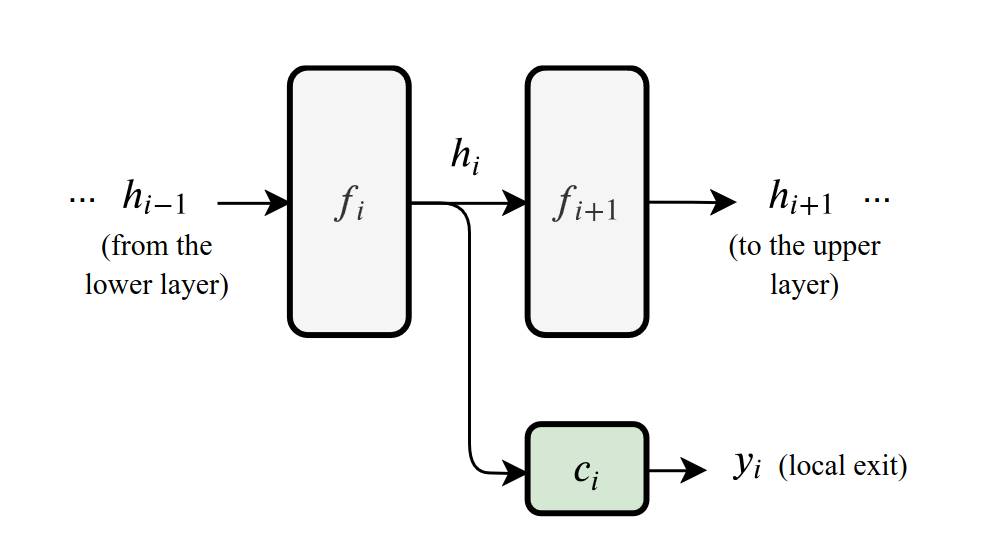

# Baseline ResNet

Please train the baseline ResNet. We will use the results from this baseline to help us understand the increases in performance that early exit can offer us.

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = baseline_model(inputs)
        loss = criterion(outputs, labels)
        baseline_optimizer.zero_grad()
        loss.backward()
        baseline_optimizer.step()
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print(f'Epoch {epoch + 1}/{num_epochs}. Loss: {loss.item()}')

Epoch 1/1. Loss: 1.3092362880706787


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = baseline_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del inputs, labels, outputs

    print(f'Accuracy of baseline network on the 5000 validation images: {correct/total * 100}')

Accuracy of baseline network on the 5000 validation images: 57.620000000000005


Question 1: How does the baseline ResNet perform on the validation set?

Your Answer Here: 55-65%

### Please Edit the ResNet code below. We want to add an optional exit after the second ResNet Block. 


Question 2:

We want to add a classifier after the 2nd resnet block as an Early Exit

1. Use Global average pooling on the feature map of the output of the 2nd layer
2. Create an MLP layer of 128 nodes
3. Use ReLU
3. Create an MLP layer of num_class nodes
4. Have the network output both the early exit result and the final result.


Edit the __init__ function and the forward_training function.

In [ ]:
class ResNetJointTraining(nn.Module):
    def __init__(
        self,
        block: Type[BasicBlock],
        layers: List[int],
        num_classes: int = 10,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
    
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.softmax = nn.Softmax(dim=1)
        ### YOUR CODE HERE
        # 1. MLP of 128 nodes
        # 2. Relu
        # 3. MLP of 10 nodes.
        self.earlyclass = nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, num_classes))
        ### END CODE HERE

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(
        self,
        block: Type[BasicBlock],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor, probability=0.395) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        ### YOUR CODE HERE
        # 1. Apply Global Average Pooling
        # 2. Apply self.earlyclass
        # 3. Apply softmax over dim=1
        # 4. Change the threshold
        gap = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2) 
        y = self.earlyclass(gap)   
        prediction, indices = torch.max(self.softmax(y), dim=1)  
        if torch.mean(prediction) > probability:
          return y, "early", torch.mean(prediction)
        ### END CODE HERE
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        prediction, indices = torch.max(self.softmax(x), dim=1)
        return x, "not early", torch.mean(prediction)

    def forward(self, x: Tensor, probability=0.395) -> Tensor:
        return self._forward_impl(x, probability)

    def forward_training(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        ### YOUR CODE HERE
        # 1. Apply Global Average Pooling
        # 2. Apply self.earlyclass
        gap = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
        y = self.earlyclass(gap)
        ### YOUR CODE HERE
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        ### YOUR CODE HERE
        # 1. Return full, early
        return x, y
        ### END CODE HERE

In [ ]:
model = ResNetJointTraining(BasicBlock, [3, 4, 6, 3]).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  
total_step = len(train_loader)

### Training with Early Exit.

Typically there are 3 types of training when utilizing early exit.
1. Training the normal network first, then freezing those weights and training early exit classifiers on top
2. Training the network up to the first exit, then training the network up to the second exit, etc.
3. Training the entire network with all the exits at the same time. 

We will proceed with strategy number 3. This is called joint training. 

The way joint training works is that the new loss is calculated as follows.

$$ L(\hat{y}) = L(\hat{{y}_{final}}) + \sum_{i=1}^{n} \alpha L(\hat{y_i})$$

Where $\hat{y_{final}}$ is the final output and $\hat{y_{i}}$ are the ith early exits.

A good number to use is $\alpha = 0.3$. We only will use one early exit in this coding assignment


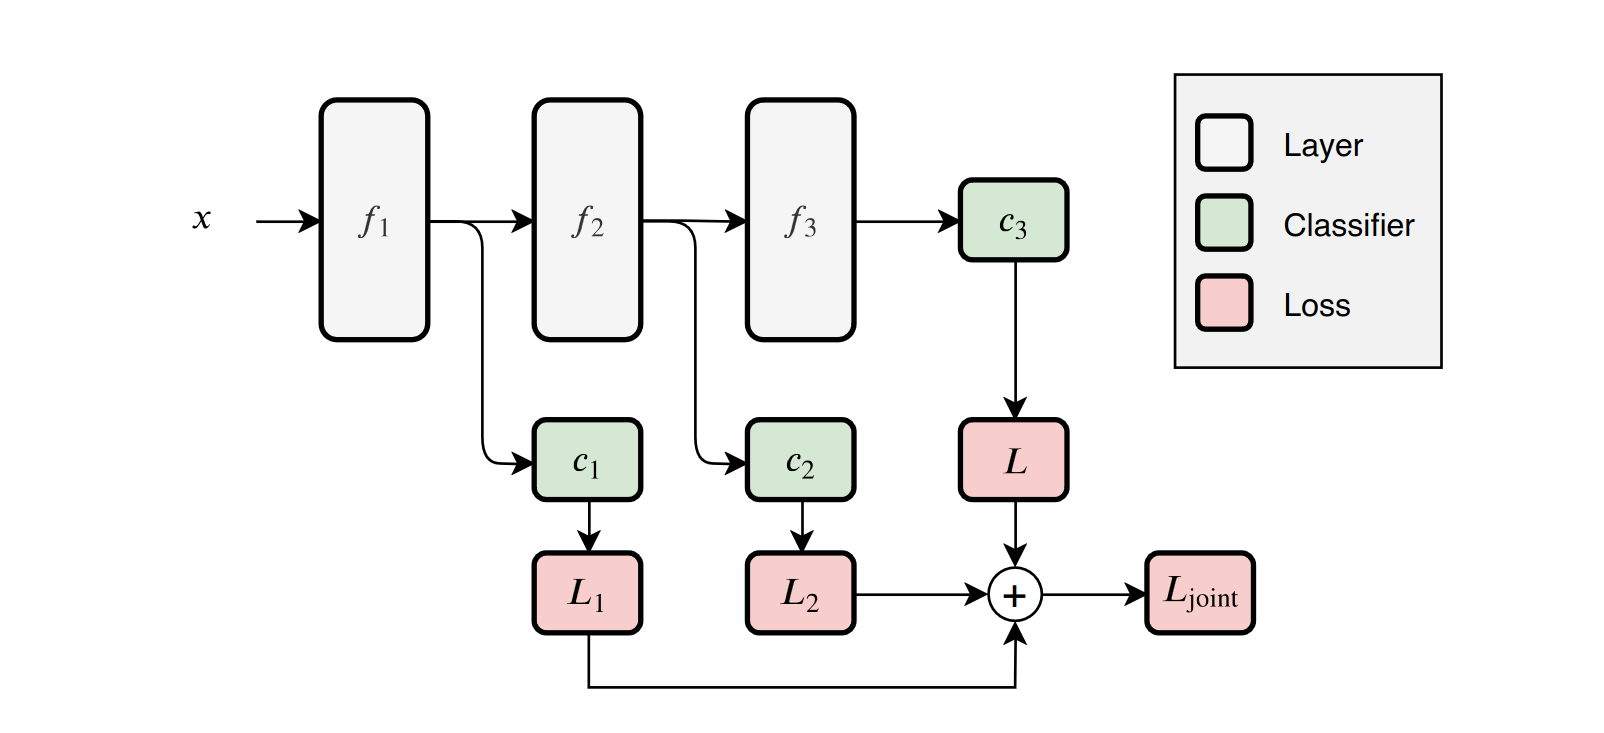

Question 3:
Please Implement the new loss function for joint training with early exit. Use $\alpha = 0.3$

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs, early = model.forward_training(inputs)
        ### YOUR CODE HERE
        loss = criterion(outputs, labels)
        loss_early = criterion(early, labels) * 0.3
        loss += loss_early
        ### YOUR CODE HERE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del inputs, labels, outputs, early
        torch.cuda.empty_cache()
        gc.collect()

    print(f'Epoch {epoch + 1}/{num_epochs}. Loss: {loss.item()}')

Epoch 1/1. Loss: 2.3136229515075684


Question 4:

Please fill in the forward() function in ResNetJointTrain. Have the model first compute the early exit logits. Apply softmax and determine the maximum probability for each example. Then, find the mean of all of the maximum probabilities. If the mean is greater than 36%, allow the model to early exit.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs, _, _ = model(inputs, 0.36)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del inputs, labels, outputs

    print(f'Accuracy of early exit network on the 5000 validation images: {correct/total * 100}')
    

Accuracy of early exit network on the 5000 validation images: 44.5


Question 5:
What is the validation accuracy of this model?

Your Answer Here: 40 - 55 percent.

In [ ]:
torch.save(model.state_dict(), "model_good")

In [ ]:
model = ResNetJointTraining(BasicBlock, [3, 4, 6, 3]).to(device)
model.load_state_dict(torch.load('model_good'))

<All keys matched successfully>

# Properties of the Early Exit Model

In [ ]:
with torch.no_grad():
    num_early_exits = 0
    total_batches = 0
    total_early_confidence = 0
    total_late_confidence = 0
    for data in valid_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs, early_exit, confidence = model(inputs,0.36)
        if early_exit == 'early':
            num_early_exits += 1
            total_early_confidence += confidence
        else:
            total_late_confidence += confidence
        total_batches += 1
        del inputs, labels, outputs
    print(f'Percent of batches that exit early: {num_early_exits/total_batches * 100}')
    print(f'Average confidence of early exit batches: {total_early_confidence/(num_early_exits + 1)}')
    print(f'Average confidence of no early exit batches: {total_late_confidence/(total_batches - num_early_exits + 1)}')

Percent of batches that exit early: 93.67088607594937
Average confidence of early exit batches: 0.3869776129722595
Average confidence of no early exit batches: 0.4654974639415741



Question 6:
How often is the model exiting early?
How confident is it when it exits early? 
How Confident is the model when it passes through the entire model?

YOUR ANSWER HERE:

Exiting Early: 60-95%

Early Exit Confidence: 30-50%

No Early Exit: 30-60%

In [ ]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)

# Comparing Early Exit with Full Inference
A MAC(Multiply and Accumulate) Opearation can be a good measure of how much compute inference is using. Please fill in the code below to determine the ratio between the number of MAC operations a model equipped with early exit needs and our baseline model. Record your answer in the cell below

Question 7:
Sum up all the total MAC operations and compute the ratio between the early exit MAC total and the baseline MAC total. Use the get_model_macs function defined above.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
total_early_exit_macs = 0
total_baseline_macs = 0
for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)
    ### YOUR CODE HERE
    total_early_exit_macs += get_model_macs(model, images)
    total_baseline_macs += get_model_macs(baseline_model, images)
    ### YOUR CODE HERE
print(min(total_early_exit_macs/total_baseline_macs, 1))

0.7720447542773595


Question 7: What is the MAC Ratio?

YOUR ANSWER HERE
50-70%

# Training a Smaller Model

In [ ]:
class ResNetSmall(nn.Module):
    def __init__(
        self,
        block: Type[BasicBlock],
        layers: List[int],
        num_classes: int = 10,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
    
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.softmax = nn.Softmax(dim=1)
        ### YOUR CODE HERE
        # 1. MLP of 128 nodes
        # 2. Relu
        # 3. MLP of 10 nodes.
        self.earlyclass = nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, num_classes))
        ### END CODE HERE

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(
        self,
        block: Type[BasicBlock],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        ### YOUR CODE HERE
        # 1. Apply Global Average Pooling
        # 2. Apply self.earlyclass
        # 3. Apply softmax over dim=1
        # 4. Change the threshold
        gap = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2) 
        y = self.earlyclass(gap)   
        return y

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


In [ ]:
model_small = ResNetSmall(BasicBlock, [3, 4, 6, 3]).to(device)
optimizer_small = torch.optim.SGD(model_small.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  
total_step = len(train_loader)

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_small.forward(inputs)
        loss = criterion(outputs, labels)
        optimizer_small.zero_grad()
        loss.backward()
        optimizer_small.step()
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print(f'Epoch {epoch + 1}/{num_epochs}. Loss: {loss.item()}')

Epoch 1/1. Loss: 1.7873362302780151


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_small(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del inputs, labels, outputs

    print(f'Accuracy of early exit network on the 5000 validation images: {correct/total * 100}')

Accuracy of early exit network on the 5000 validation images: 49.559999999999995


Question 8: What is the accuracy of the small Resnet?

YOUR ANSWER HERE:
40-55%

# Hyperparameter Searching for the Optimal Early Exit Threshold

We want to determine when to let the model early exit. There are tradeoffs of latency and accuracy that we want to balance with this decision.

Lets Hyperparameter search for a more optimal threshold. Currently the threshold is 36% confidence, but can you find a better one?

Find the minimum threshold such that we have a better accuracy than the small model.

In [ ]:
def accuracy_at_probability_p(p):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs, _, _ = model(inputs, p)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del inputs, labels, outputs

        print(f'Accuracy of early exit network on the 5000 validation images: {correct/total * 100}')
def macs_at_p(p):
    total_early_exit_macs = 0
    total_baseline_macs = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        ### YOUR CODE HERE
        total_early_exit_macs += get_model_macs(model, (images, p))
        total_baseline_macs += get_model_macs(baseline_model, images)
        ### YOUR CODE HERE
    print(min(total_early_exit_macs/total_baseline_macs, 1))

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# YOUR CODE HERE
for p in [0.394+i/1000 for i in range(0,100)]:
# YOUR CODE HERE
    print(f'Threshold of {p}')
    accuracy_at_probability_p(p)
    macs_at_p(p)

Threshold of 0.394
Accuracy of early exit network on the 5000 validation images: 49.68
0.7513215501203642
Threshold of 0.395
Accuracy of early exit network on the 5000 validation images: 50.239999999999995


KeyboardInterrupt: ignored

Question 9: Please report your findings 

Any value between 0.39 and 0.41 should be correct. The MAC decrease should be about 20-30%

Sources:

Images from: https://arxiv.org/pdf/2004.12814.pdf

ResNet Code adapted from https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L266

Credit to:
TorchVision maintainers and contributors. (2016). TorchVision: PyTorch's Computer Vision library [Computer software]. https://github.com/pytorch/vision
